<a href="https://colab.research.google.com/github/INA-95/spotify_api/blob/main/Spotify_api_231025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
# library

import requests
import base64
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [134]:
# Function

# authorization

def get_access_token(client_id:str, client_secret:str) -> str:
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_header = {
        'Authorization': f'Basic {base64.b64encode((client_id + ":" + client_secret).encode()).decode()}'
    }

    auth_data = {
        'grant_type': 'client_credentials',
        'client_id' : client_id,
        'client_secret' : client_secret
    }

    auth_response = requests.post(auth_url, data = auth_data, headers = auth_header)
    auth_response_data = auth_response.json()
    access_token = auth_response_data['access_token']
    return access_token


# get your playlists

def get_playlists(access_token:str, user_name:str) -> dict:
    headers = {"Authorization" : f"Bearer {access_token}"}
    res = requests.get(
        f"https://api.spotify.com/v1/users/{user_name}/playlists",
        headers = headers
    )

    playlist_array = res.json()['items']
    playlist_dict = {playlist['id']:playlist['name'] for playlist in playlist_array}

    return playlist_dict


# get your tracks (playlist > track)

def get_playlist_tracks(access_token:str, playlist_dict:list[str], user_name:str) -> dict:
    headers = {"Authorization": f"Bearer {access_token}"}
    offset = 0

    tracks = []
    playlist_ids = [playlist_id for playlist_id in playlist_dict.keys()]

    for playlist_id in playlist_ids:

        res = requests.get(
            f"https://api.spotify.com/v1/users/{user_name}/playlists/{playlist_id}/tracks?offset={offset}",
            headers=headers
        )
        track = res.json()
        tracks.append(track)

    return tracks

# get artist, title, track_id

def get_track_info(tracks:list[dict[str]]) -> pd.DataFrame:

    artists = []
    titles = []
    track_ids = []

    for track in tracks:
        for val in track['items']:
            track_info = val.get('track')

            artist = track_info.get('artists')
            artist = artist[0]['name']

            title = track_info.get('name')
            track_id = val.get('track')['uri'].split(':')[-1]

            artists.append(artist)
            titles.append(title)
            track_ids.append(track_id)

        df = pd.DataFrame(list(zip(titles, artists, track_ids)),
                        columns = ['title', 'artist', 'track_id'])

    return df


# get your tracks audio feature

def tracks_audio_features(access_token:str, track_ids:list[str]) -> pd.DataFrame:

    feature_lst = []

    for track_id in track_ids:
        headers = {"Authorization" : f"Bearer {access_token}"}
        res = requests.get(
            f"https://api.spotify.com/v1/audio-features/{track_id}",
            headers = headers
        )
        feature = res.json()

        feature_lst.append(feature)
        df = pd.DataFrame.from_dict(feature_lst)

    return df

In [135]:
# Implementation

client_id = "02f33cf8e07c4252a19ff6fbfb08a49c"
client_secret = "b7bb07ef5d4f470ba2552b14eb77453f"
user_name = "31r4cwv3wp265xtmbmm7z2y34ehq"

access_token = get_access_token(client_id, client_secret)
playlist_dict = get_playlists(access_token, user_name)
tracks = get_playlist_tracks(access_token, playlist_dict, user_name)

In [136]:
df1 = get_track_info(tracks)
df1.drop_duplicates(inplace = True)

track_ids = [track_id for track_id in df1['track_id']]
df2 = tracks_audio_features(access_token, track_ids)

final = df1.merge(df2, how = 'inner', left_on = 'track_id', right_on = 'id')
final.head()

,title,artist,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,PLAY,LUCY,0ddSLVdbpKFO1FtIYpYnw9,0.424,0.663,5,-4.133,1,0.0391,0.63400,...,0.1120,0.196,186.093,audio_features,0ddSLVdbpKFO1FtIYpYnw9,spotify:track:0ddSLVdbpKFO1FtIYpYnw9,https://api.spotify.com/v1/tracks/0ddSLVdbpKFO...,https://api.spotify.com/v1/audio-analysis/0ddS...,226880,4
1,Replay,SHINee,1rp986nzkyAX1wFpxzbwlC,0.716,0.779,1,-2.203,1,0.0805,0.17800,...,0.1670,0.590,99.977,audio_features,1rp986nzkyAX1wFpxzbwlC,spotify:track:1rp986nzkyAX1wFpxzbwlC,https://api.spotify.com/v1/tracks/1rp986nzkyAX...,https://api.spotify.com/v1/audio-analysis/1rp9...,213827,4
2,What's Happening?,B1A4,0pssH13oORltxWa5MIvEuI,0.623,0.745,9,-3.536,1,0.0562,0.00461,...,0.1590,0.698,135.013,audio_features,0pssH13oORltxWa5MIvEuI,spotify:track:0pssH13oORltxWa5MIvEuI,https://api.spotify.com/v1/tracks/0pssH13oORlt...,https://api.spotify.com/v1/audio-analysis/0pss...,200346,4
3,Trouble Maker,Trouble Maker,0RP3Qjp1QhIjhtG7gYoBqn,0.838,0.805,10,-2.723,0,0.0541,0.08260,...,0.0778,0.952,115.026,audio_features,0RP3Qjp1QhIjhtG7gYoBqn,spotify:track:0RP3Qjp1QhIjhtG7gYoBqn,https://api.spotify.com/v1/tracks/0RP3Qjp1QhIj...,https://api.spotify.com/v1/audio-analysis/0RP3...,219638,4
4,12:30,Beast,0uvl4TuFhdWZshHX9Hd6kI,0.637,0.792,1,-2.932,1,0.0330,0.34600,...,0.0743,0.536,99.909,audio_features,0uvl4TuFhdWZshHX9Hd6kI,spotify:track:0uvl4TuFhdWZshHX9Hd6kI,https://api.spotify.com/v1/tracks/0uvl4TuFhdWZ...,https://api.spotify.com/v1/audio-analysis/0uvl...,233848,3


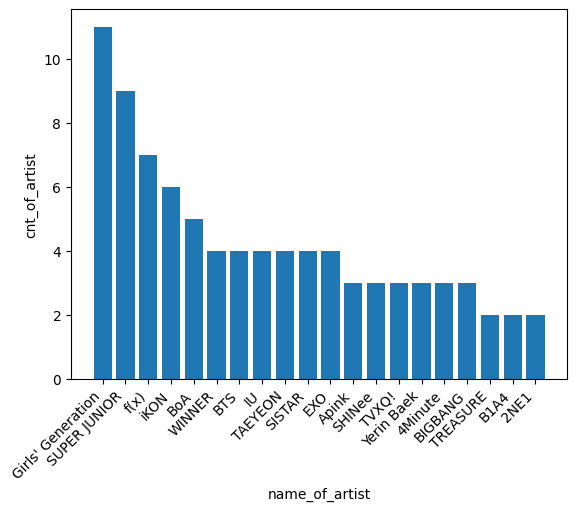

In [137]:
# favorite artist

fav_artist = final['artist'].value_counts().reset_index().head(20)

fig, ax = plt.subplots()
x = fav_artist['index'].tolist()
y = fav_artist['artist'].tolist()
ax.bar(x, y)
ax.set_ylabel('cnt_of_artist')
ax.set_xlabel('name_of_artist')
plt.xticks(rotation = 45, ha = 'right')

plt.show()

In [138]:
# Audio feature analysis

audio_feature_df = final[['title', 'artist', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
audio_feature_df.head()

,title,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,PLAY,LUCY,0.424,0.663,-4.133,0.0391,0.63400,0.000095,0.1120,0.196,186.093
1,Replay,SHINee,0.716,0.779,-2.203,0.0805,0.17800,0.000001,0.1670,0.590,99.977
2,What's Happening?,B1A4,0.623,0.745,-3.536,0.0562,0.00461,0.000000,0.1590,0.698,135.013
3,Trouble Maker,Trouble Maker,0.838,0.805,-2.723,0.0541,0.08260,0.000004,0.0778,0.952,115.026
4,12:30,Beast,0.637,0.792,-2.932,0.0330,0.34600,0.000000,0.0743,0.536,99.909


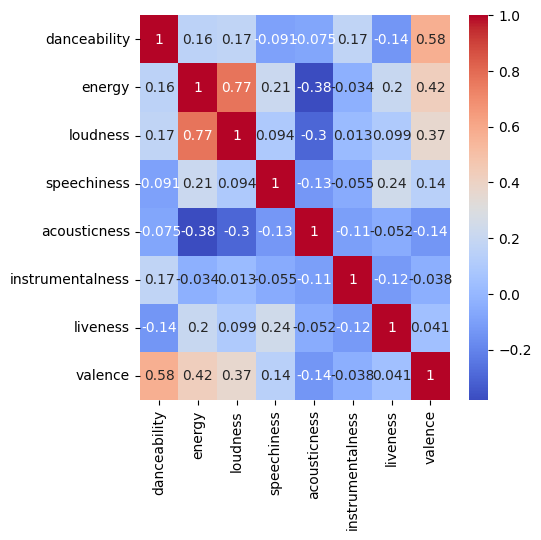

In [139]:
# Correlation between audio features

target_vals = audio_feature_df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
f, ax = plt.subplots(figsize = (5, 5))
ax = sns.heatmap(target_vals.corr(), annot = True, cmap = 'coolwarm')

In [140]:
# Top_N song by each of audio feature

def top_n_song_by_audio_feature(df:pd.DataFrame, feature:str, n:int):
    df = df[['title', 'artist', feature]].sort_values(by = feature, ascending = True).head(n)

    titles = [title for title in df['title']]
    features = [feature for feature in df[feature]]
    y = np.arange(n)

    plt.barh(y, features)
    plt.yticks(y, titles)

    plt.show()

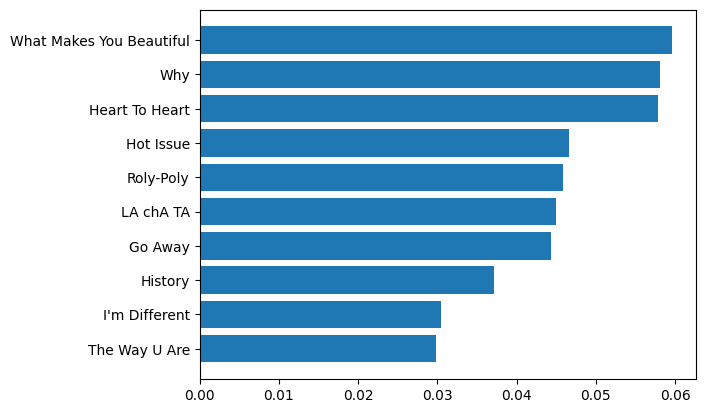

In [ ]:
top_n_song_by_audio_feature(audio_feature_df, 'liveness', 10)

### Audio Feature Clustering

In [ ]:
audio_features_df = final[['danceability', 'energy', 'loudness', 'speechiness',
                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]

In [ ]:
# Audio feature Clustering
# Normalizing

scaler = preprocessing.MinMaxScaler()
audio_features_normal = scaler.fit_transform(audio_features_df)
audio_features_normal = pd.DataFrame(audio_features_normal)
audio_features_normal.columns = audio_features_df.columns

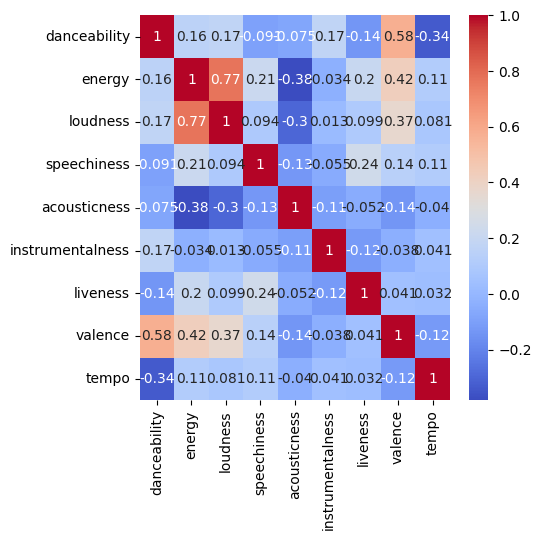

In [ ]:
# Heatmap of Normalized data

target_vals = audio_features_normal[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']]
f, ax = plt.subplots(figsize = (5, 5))
ax = sns.heatmap(target_vals.corr(), annot = True, cmap = 'coolwarm')

In [167]:
# PCA

scaler = StandardScaler()
X_std = scaler.fit_transform(audio_features_df)

In [ ]:
pca = PCA()
pca.fit(X_std);

In [170]:
evr = pca.explained_variance_ratio_
evr

array([0.27611171, 0.1842399 , 0.13122119, 0.10549213, 0.09295912,
       0.08509553, 0.06723013, 0.03454489, 0.02310541])

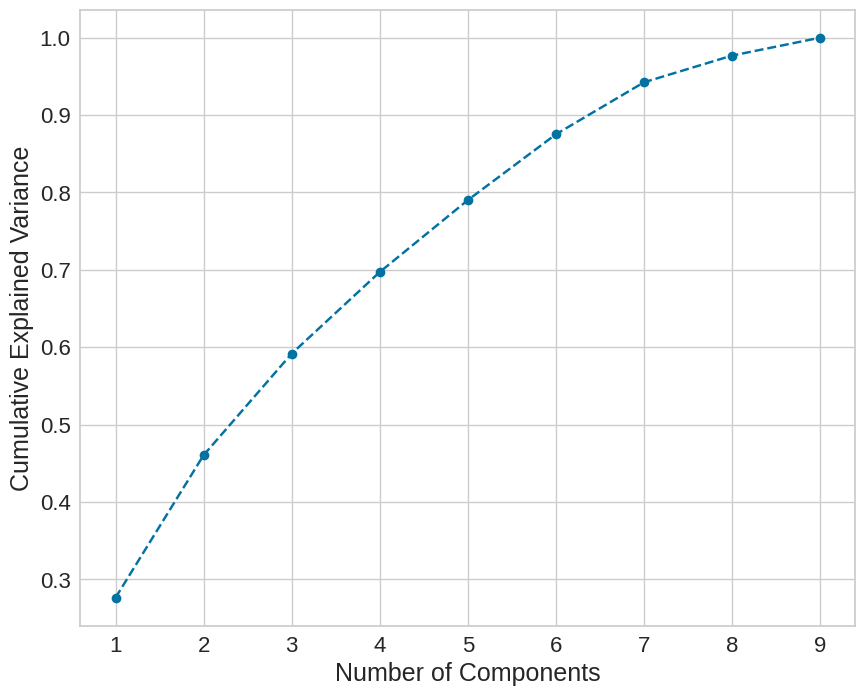

In [179]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(audio_features_df.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [180]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Number of components: 6


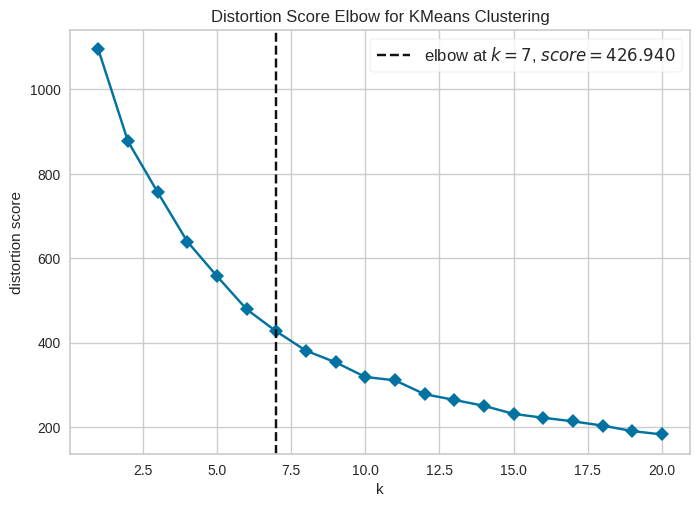

Optimal number of clusters: 7


In [181]:
visualizer = KElbowVisualizer(KMeans(init='k-means++', random_state=42), k=(1,21), timings=False)
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [182]:
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

In [183]:
df_seg_pca_kmeans = pd.concat([audio_features_df.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
0,0.424,0.663,-4.133,0.0391,0.63400,0.000095,0.1120,0.196,186.093,3.219111,2.784074,1.367942,-1.835965,2.360774,1.155820,4
1,0.716,0.779,-2.203,0.0805,0.17800,0.000001,0.1670,0.590,99.977,-0.475157,-0.288100,-0.188339,-0.188439,-0.376902,-0.128989,1
2,0.623,0.745,-3.536,0.0562,0.00461,0.000000,0.1590,0.698,135.013,-0.156685,0.675713,0.796620,-0.376006,-0.084872,-0.577352,1
3,0.838,0.805,-2.723,0.0541,0.08260,0.000004,0.0778,0.952,115.026,-1.505773,-1.437587,0.159428,-0.434649,0.451357,-0.569555,1
4,0.637,0.792,-2.932,0.0330,0.34600,0.000000,0.0743,0.536,99.909,0.577480,-0.468905,0.051012,-1.118429,-0.154021,0.295879,5


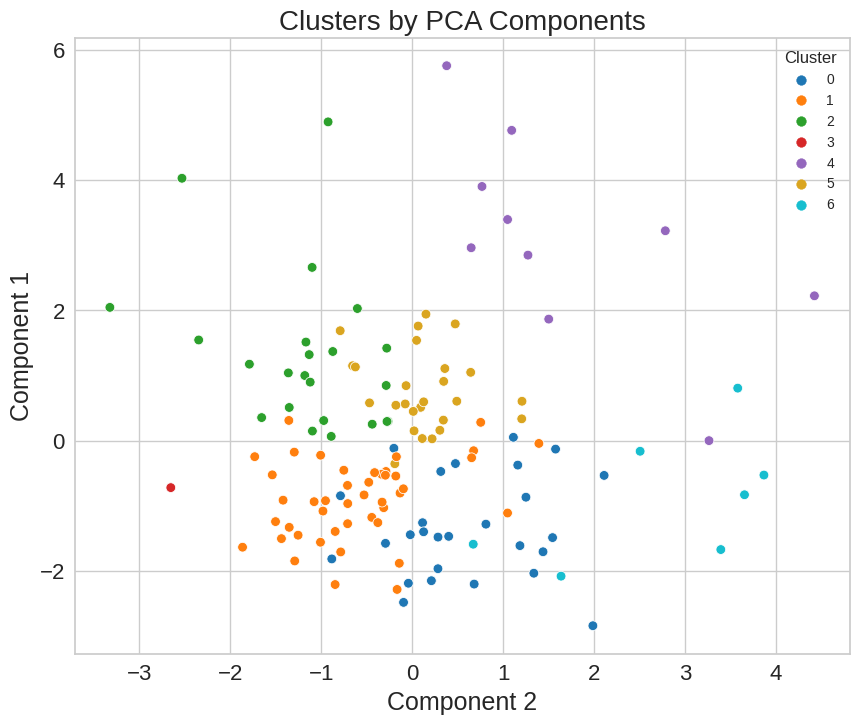

In [195]:
fig = plt.figure(figsize=(10, 8))

sns.scatterplot(data=df_seg_pca_kmeans,
                x='Component 2', y='Component 1',
                hue = 'Cluster',
                palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                           'tab:purple', 'goldenrod', 'tab:cyan'])
plt.title('Clusters by PCA Components', fontsize=20)
plt.xlabel("Component 2", fontsize=18)
plt.ylabel("Component 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()